# Machine Learning project CS-433: NMR spectroscopy supervised learning



___

## Schedules:

* Week 10 (18-24 November): 
 * Tests of various linear models/simple NN on a 10% subset of data
* Week 11 (25-1 December):
 * Feature selection: being able to come with a good set of features
* Week 12 (2-8 December):
 * Start of big scale analysis, implementation of the models which perform well at small scale
* Week 13 (9-15 December):
 * Wrapping up
* Week 14 (16-22 December): 
 * 19th December: Deadline

___

## Table of contents

1. [Log Book](#log)
2. [Pipeline](#pipeline)
3. [Data Processing](#data_proc) <br>
&emsp;3.1. [Data Vizualisation](#data_viz) <br>
&emsp;3.2 [Outliers detection](#outliers) <br>
  &emsp;&emsp;3.2.1 [DBSCAN](#dbscan) <br>
  &emsp;&emsp;3.2.2 [Inter quantile range method](#iqr) <br>
&emsp;3.3 [Scaling](#scaling) <br>
&emsp;&emsp;3.3.1 [Min max scaling](#minmax) <br>
&emsp;3.4 [Dimensionality reduction](#dim_red) <br>
  &emsp;&emsp;3.4.1 [PCA](#pca) <br>
&emsp;3.5 [Feature Selection](#feat_sel) <br>
  &emsp;&emsp;3.5.1 [Relative importance from linear regression](#rel_imp_lin) <br>
  &emsp;&emsp;3.5.2 [Random forest](#rand_for) <br>
  &emsp;&emsp;3.5.3 [Univariate feature selection](#un_feat_sel) <br>
  &emsp;&emsp;3.5.4 [Recursive feature selection](#rec_feat_sel) <br>
  &emsp;&emsp;3.5.5 [Lasso Regression](#lasso) <br>
  &emsp;&emsp;3.5.6 [Boruta](#boruta) <br>
&emsp;3.6 [Models](#models) <br>
  &emsp;&emsp;3.6.1 [Linear Models](#lin_mods) <br>
  &emsp;&emsp;3.6.2 [Neural Networks](#NN) <br>
4. [Main](#main) <br>
   4.1 [ANN implementation](#ann_imp) <br>
    

In [16]:
import os
import scipy.stats
import sklearn.metrics
import warnings

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_selection import RFE
from sklearn.feature_selection import SelectFromModel
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler

import pickle
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectKBest,f_regression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
from sklearn.linear_model import LinearRegression,Ridge,Lasso,ElasticNet

# For neural net part


import torch 
import torch.nn as nn
import torch.nn.functional as F
from torch import optim


from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.optimizers import Adam, SGD
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization


%load_ext autoreload
%autoreload 2
import sys, os
sys.path.append(os.path.join(sys.path[0],'src'))
import helpers as hl
import data_viz as dv
import outliers as out
import lin_mods as lm
import neural_nets as nrn
import NN3 as nn3
import k_models

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 0. Import data
<a id='import'></a>

In [13]:
data_folder = '../data'
NB_TRAINS = 1000

files = os.listdir(data_folder)  
X_files = [filename for filename in files if (filename.endswith('.npy') and ('rsr' in filename))]
y_files = [filename for filename in files if (filename.endswith('.npy') and ('chemical_shielding' in filename))]


tot_data_X = np.load(data_folder + '/' + X_files[1], mmap_mode='r')
tot_data_Y = np.load(data_folder + '/' + y_files[0], mmap_mode='r')

tot_data_X,X_test_final,tot_data_Y,y_test_final = train_test_split(tot_data_X,tot_data_Y,test_size = 0.1,random_state = 14)


In [91]:
print(tot_data_X.shape)
print(tot_data_Y.shape)

(34662, 14400)
(34662,)


## 1. Data Vizualisation
<a id='data_viz'></a>

### 1.1 Feature Distribution

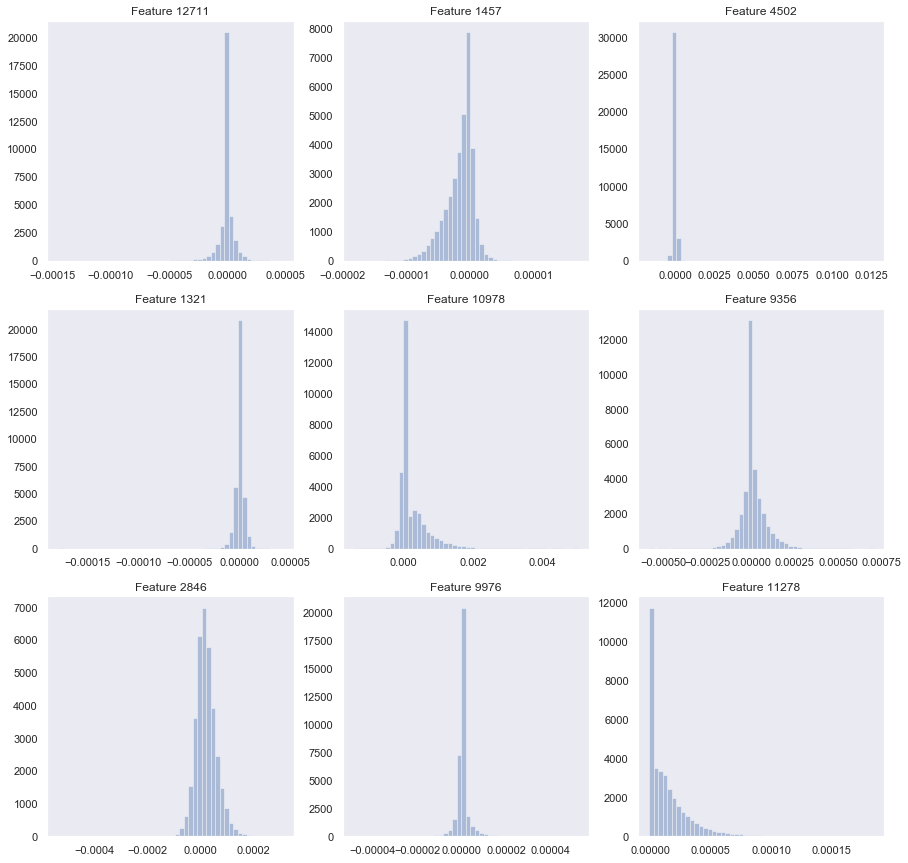

In [92]:
dv.plot_feature_dist(tot_data_X)

<div class="alert alert-block alert-success">

We see that the different features are scaled pretty differently, we might want to scale them beforehand. Since they don' look like following a gaussian, we'll apply min/max scaling: but in order to do so, we first need to get rid of the outliers thanks to one of the following methods
    
* Zscore: not adapted as our data might not be gaussian
* DBScan
* Isolation Forest
    </div>

## 2. Data preprocessing
<a id='preprocess'></a>

### 2.1 Outliers detection
<a id='outliers'></a>

#### 2.2.2 Interquartile range method (IQR)
<a id = 'iqr'></a>

<div class="alert alert-block alert-success">
Consists in considering as outliers all data points that lie in >1.5 interquartile range from the quartiles:

* Method 1: removing the samples which are considered as outliers in their label
* Method 2: removing the samples which are considered as outliers for any of the x features
    </div>

In [99]:
with open('../pickle_files/scores_IQR_methods.pickle', 'rb') as f:
    try:
        (scores1,scores2) = pickle.load(f)
        print('Successful read.')
    except :
        # load a subset of the data
        data_X, data_y = hl.load_data(NB_TRAINS, tot_data_X, tot_data_Y)

        lin = LinearRegression()
        SCORING = ['neg_mean_squared_error', 'neg_mean_absolute_error','r2']

        #method 1
        out_remover = out.IQR_outlier()
        out_remover.fit(data_X)
        data_X1,data_y1 = out_remover.transform(data_X,data_y)
        scores1 = cross_validate(lin, data_X1, data_y1, cv=10,scoring = SCORING)

        #method 2
        data_X2,data_y2 = out.IQR_y_outliers(data_X,data_y)
        scores2 = cross_validate(lin,data_X,data_y,cv = 10,scoring = SCORING)

Successful read.


<div class="alert alert-block alert-success">

We compare the 2 methods on a classic linear regression task in order to assess which one performs better: 
    </div>

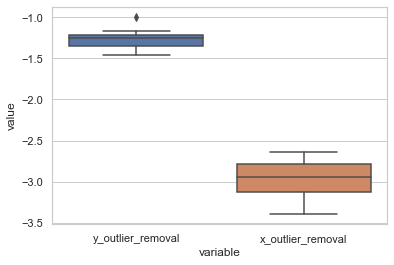

In [106]:
def plot_box_plot(scores1,scores2,metric):
    sns.set(style="whitegrid")
    scores_df = pd.DataFrame({'y_outlier_removal':scores1[metric],'x_outlier_removal':scores2[metric]})
    sns.boxplot(x="variable", y="value", data=pd.melt(scores_df))
plot_box_plot(scores1,scores2,'test_neg_mean_absolute_error')

<div class="alert alert-block alert-success">

It turns out that removing data with erronate labels is way more efficient in terms of MSE: we'll prefer this method over the second one over the project. One still needs to assess its efficiency at a larger scale though, which is done in the following section.
    </div>

<div class="alert alert-block alert-success">
We now study the effet of this method  with the number of datas: it leads to a slight improvement and a noticeable reduction of variance.
    </div>

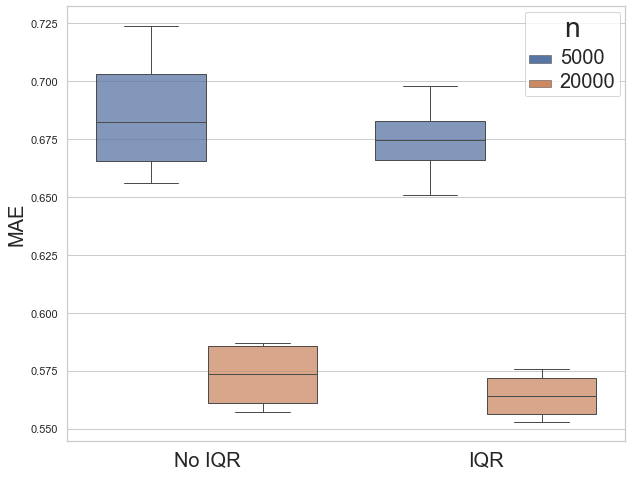

In [95]:
with open('../pickle_files/stats_iqr_vs_n.pkl', 'rb') as f: 
        noiqr_5000_mse, noiqr_20000_mse, iqr_5000_mse, iqr_20000_mse, noiqr_5000_mae, noiqr_20000_mae, iqr_5000_mae, iqr_20000_mae, noiqr_5000_r2, noiqr_20000_r2, iqr_5000_r2, iqr_20000_r2 = pickle.load(f)
dv.plot_iqr_effect(noiqr_5000_mae, noiqr_20000_mae, iqr_5000_mae, iqr_20000_mae)

<div class="alert alert-block alert-success">
Visual interpretation of the outliers removal method
</div>

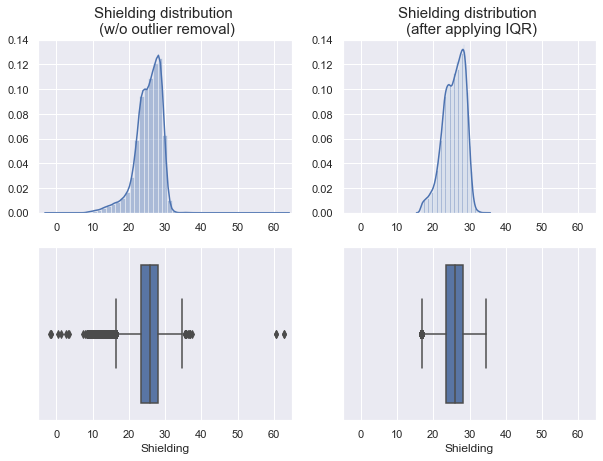

In [110]:
X_filtered, y_filtered = out.IQR_y_outliers(tot_data_X, tot_data_Y)

dv.plot_iqr(tot_data_Y, y_filtered)

## 2.2 Dimension Reduction

#### 2.2.1 PCA
<a id='pca'></a>

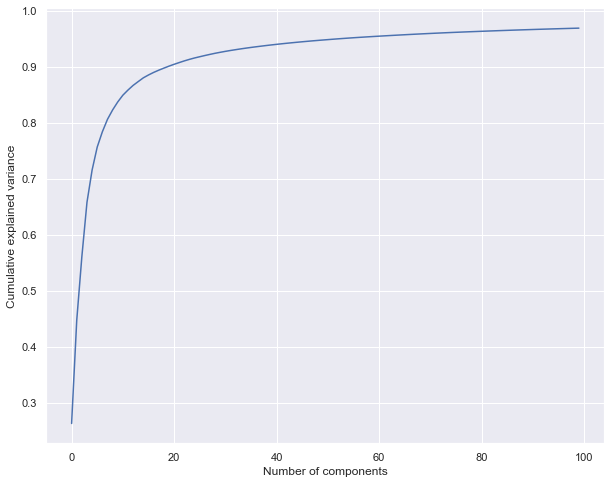

In [111]:
data_X,data_y = hl.load_data(NB_TRAINS,tot_data_X,tot_data_Y)
dv.plot_PCA(100,data_X)

<div class="alert alert-block alert-success">
When using <b>PCA</b>, we selected a number of components equal to the $98\%$ of the total explained variance, <i>i.e.</i> 80 principle components.
</div>

## 2.4 Feature Selection
<a id='feat_sel'></a>

#### 3.5.3 Univariate feature selection
<a id='un_feat_sel'></a>

<div class="alert alert-block alert-success">
Running univariate feature selection on the laptops turned out to be extremely costly: this is why we performed it after running a PCA on the trained subset of data. This was before having access to more computational power, which allowed us to perform RFS.
</div>

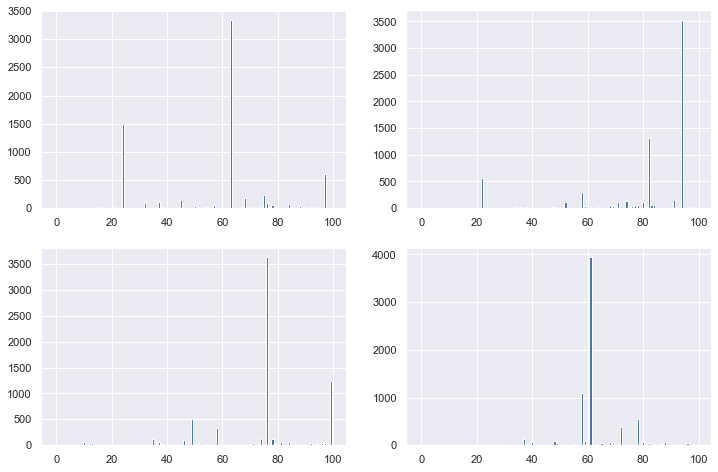

In [113]:
fig,axes = plt.subplots(2,2,figsize = (12,8))
for i in range(4):
    data_X,data_y = hl.load_data(NB_TRAINS,tot_data_X,tot_data_Y)
    pca = PCA(n_components = 100)
    pca.fit(data_X)
    data_X_pca = pca.transform(data_X)
    hl.univ_feat_sel(data_X_pca,data_y,ax = axes[np.unravel_index(i,(2,2))])

<div class="alert alert-block alert-success">
As we can see, the importance of the various PCs is not regular across various random samples for data_X: this is probably due to the fact that the PCs are not the same for a different subset of data. 
    </div>

#### 3.5.4 Recursive feature elimination
<a id='rec_feat_sel'></a>

<div class="alert alert-block alert-success">
RFE turns out to be extensively demanding in computational power: it crashed many times on our laptops. Nevertheless, the results it gave us allowed the various linear/NN models to perform as good and even better for a computational time drastically reduced. The optimal alpha found in the next section is used in order to perform this feature selection.
    </div>

In [7]:
with open('../pickle_files/RFE.pickle', 'rb') as f:
    try:
        print('Successful read.')
        rfe = pickle.load(f)
    except :
        ridge = Ridge(alpha=0.003)
        rfe = RFE(ridge,step = 0.05,verbose = True)
        fit = rfe.fit(tot_data_X,tot_data_Y)
        print("Num Features: %d" % fit.n_features_)
        print("Selected Features: %s" % fit.support_)
        print("Feature Ranking: %s" % fit.ranking_)

Successful read.


In [117]:
print('RFE selects %i features' % rfe.n_features_)

RFE selects 2160 features


## 2.5 Linear Models Optimization
<a id='models'></a>

In [14]:
data_X, data_y = hl.load_data(100,tot_data_X,tot_data_Y)
interv = np.logspace(np.log10(0.00001),np.log10(10000),30)
K = 8

### 2.5.1 Ridge Regression

0.0030391953823131978


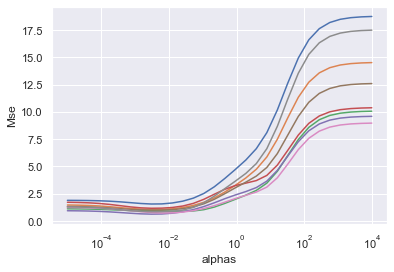

In [122]:
alph_opt = lm.test_alphas_meth(Ridge,interv,data_X,data_y,k = K)
print(alph_opt)

### 2.5.2 Lasso Regression

0.0007278953843983154


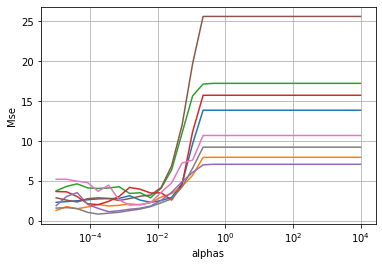

In [17]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    alph_opt = lm.test_alphas_meth(Lasso,interv,data_X,data_y,k = K,)
    print(alph_opt)

### 2.5.3 Elastic Nets

0.00017433288221999874


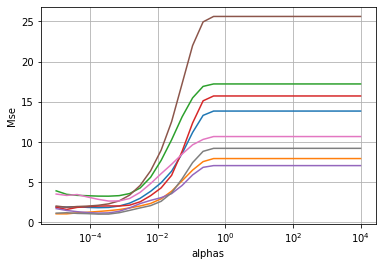

In [18]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    alph_opt = lm.test_alphas_meth(ElasticNet,interv,data_X,data_y,k = K)
    print(alph_opt)

## 2.6 Neural Networks
<a id='pytorch'></a>

### 2.1 Pytorch NN

<div class="alert alert-block alert-success">

The best results were reached using RFE followed by a training on XXXXX samples on the architecture 5 of `neural_nets.py`
    </div>

_c.f._ `neural_nets.py` file.

### 2.2 Keras NN
<a id='keras'></a>

_c.f._ `k_models.py` file.

### 2.2 NN3

<div class="alert alert-block alert-success">

We developped a ensemble method taking an object oriented form as a class who could take advantage of the non redondant information of the 3 different datasets. Since the best architecture was the same for the 3 datasets, the class sequentially trains on times the same architecture on each dataset, before "averaging" their respecive inputs thanks to the following formula (which is robust to outliers, and assumes that as 2 predictions are close, it is not by chance and that we should not take the third one into account. 
    </div>

$\bar{y} = \frac{\sum_{j \in S} \sum_{j \in S,i \neq j}\frac{1}{a_{ij}}y_{i}}{\sum_{j \in S}\sum_{i \in S,i \neq j}\frac{1}{a_{ij}}},a_{ij} = |y_{i} - y_{j}|$

_c.f._ `NN3.py` file.

## 3. Main
<a id='main'></a>

<div class="alert alert-block alert-success">

The main consists of the different grid search for linear models and trainings for NN.
    </div>

### 3.1 Linear Models Pipelines
<a id='main_pytorch'></a>

<div class="alert alert-block alert-success">

Each cell here is meant to do a whole pipeline, from loading a certain number of samples, preprocessing etc. We keep using the R2 score, the MSE and the MAE as our metrics.
    </div>

In [6]:
SCORING = ['neg_mean_squared_error', 'neg_mean_absolute_error','r2']
path_dic = {'CSD-10k_H_fps_1k_MD_n_12_l_9_rc_3.0_gw_0.3_rsr_1.0_rss_2.5_rse_5':'3angst',
           'CSD-10k_H_fps_1k_MD_n_12_l_9_rc_5.0_gw_0.3_rsr_1.0_rss_2.5_rse_5':'5angst',
           'CSD-10k_H_fps_1k_MD_n_12_l_9_rc_7.0_gw_0.3_rsr_1.0_rss_2.5_rse_5':'7angst'}

data_path = 'CSD-10k_H_fps_1k_MD_n_12_l_9_rc_5.0_gw_0.3_rsr_1.0_rss_2.5_rse_5'
n_samples = 8000
with open('../pickle_files/RFE.pickle', 'rb') as f:
    print('Successful read.')
    rfe = pickle.load(f)
K = 4

Successful read.


### Pipeline 0: Pure Ridge

In [5]:
data_X,data_y = hl.load_data(n_samples,tot_data_X,tot_data_Y)

rid = Ridge()
pipeline = Pipeline([
  ('rid', rid)
])

param_grid = {
    'rid__alpha': np.logspace(np.log10(0.00001),np.log10(10),10)
}

cv = KFold(n_splits = K)
search = GridSearchCV(pipeline, param_grid, scoring = 'neg_mean_absolute_error',iid=False, cv=cv)
search.fit(data_X,data_y)

best_score = search.best_score_
bp_ = search.best_params_
be_ = search.best_estimator_

#refit with the best parameters
pipeline.set_params(rid__alpha = bp_['rid__alpha'])

results = cross_validate(pipeline,data_X, data_y, cv = cv,scoring=SCORING)
lm.log_model(results,pipeline,param_grid,path_dic[data_path])

lm.display_score(results)

print(search.best_estimator_.named_steps)

KeyError: 'CSD-10k_H_fps_1k_MD_n_12_l_9_rc_3.0_gw_0.5_rsr_1.0_rss_2.5_rse_5'

#### Pipeline 1

In [8]:
data_X,data_y = hl.load_data(n_samples,tot_data_X,tot_data_Y)

data_X,data_y = out.IQR_y_outliers(data_X,data_y)

pca = PCA()
min_max = MinMaxScaler()
rid = Ridge()
sel = SelectKBest(score_func=f_regression)
pipeline = Pipeline([
  ('min_max',min_max),
  ('feat_sel', sel),
  ('pca',pca),
  ('rid', rid)
])

param_grid = {
    'pca__n_components': [80,90,100],
    'rid__alpha': np.logspace(np.log10(0.001),np.log10(100),4),
    'feat_sel__k': [2000,3000],
}

cv = KFold(n_splits = K)
search = GridSearchCV(pipeline, param_grid, scoring = 'neg_mean_absolute_error',iid=False, cv=cv)
search.fit(data_X,data_y)

best_score = search.best_score_
bp_ = search.best_params_
be_ = search.best_estimator_

#refit with the best parameters
pipeline.set_params(pca__n_components= bp_['pca__n_components'],feat_sel__k = bp_['feat_sel__k'],rid__alpha = bp_['rid__alpha'])

results = cross_validate(pipeline,data_X, data_y, cv = cv,scoring=SCORING)
lm.log_model(results,pipeline,param_grid,path_dic[data_path])

lm.display_score(results)

print(search.best_estimator_.named_steps)

Log saved
On 4 folds
Obtained MSE on test set 1.06 
Obtained MAE on test set 0.78 
Obtained r2 on test set 0.88 
{'min_max': MinMaxScaler(copy=True, feature_range=(0, 1)), 'feat_sel': SelectKBest(k=3000, score_func=<function f_regression at 0x1a1ef87440>), 'pca': PCA(copy=True, iterated_power='auto', n_components=100, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False), 'rid': Ridge(alpha=0.046415888336127795, copy_X=True, fit_intercept=True,
      max_iter=None, normalize=False, random_state=None, solver='auto',
      tol=0.001)}


#### Pipeline 2

In [9]:
#Pipeline 2

data_X,data_y = hl.load_data(n_samples,tot_data_X,tot_data_Y)
data_X = data_X[:,rfe.support_]



#data_X,data_y = out.IQR_y_outliers(data_X,data_y)

rid = Ridge()
pipeline = Pipeline([
  ('rid', rid)
])

param_grid = {
    'rid__alpha': np.logspace(np.log10(0.001),np.log10(1000),10),
}

cv = KFold(n_splits = K)
search = GridSearchCV(pipeline, param_grid, scoring = 'neg_mean_absolute_error',iid=False, cv=cv)
search.fit(data_X,data_y)

best_score = search.best_score_
bp_ = search.best_params_
be_ = search.best_estimator_

pipeline.set_params(rid__alpha = bp_['rid__alpha'])


results = cross_validate(pipeline,data_X, data_y, cv = cv,scoring=SCORING)
lm.log_model(results,pipeline,param_grid,path_dic[data_path])

lm.display_score(results)

print(search.best_estimator_.named_steps)

Log saved
On 4 folds
Obtained MSE on test set 0.58 
Obtained MAE on test set 0.54 
Obtained r2 on test set 0.96 
{'rid': Ridge(alpha=0.001, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)}


#### Pipeline 3

In [10]:
#Pipeline 3

data_X,data_y = hl.load_data(n_samples,tot_data_X,tot_data_Y)

data_X,data_y = out.IQR_y_outliers(data_X,data_y)

pca = KernelPCA()
min_max = MinMaxScaler()
rid = Ridge()
pipeline = Pipeline([
  ('min_max',min_max),
  ('pca',pca),
  ('ridge', rid)
])

param_grid = {
    'pca__n_components': [80, 100],
    'ridge__alpha': np.logspace(np.log10(0.001),np.log10(1000),5),
    'pca__kernel': ['linear','poly','rbf'],
    'pca__degree': [2,4,6],
    'pca__gamma': [0.2,1.0,1.5]
}

cv = KFold(n_splits = K)
search = GridSearchCV(pipeline, param_grid, scoring = 'neg_mean_absolute_error',iid=False, cv=cv)
search.fit(data_X,data_y)

best_score = search.best_score_
bp_ = search.best_params_
be_ = search.best_estimator_

pipeline.set_params(pca__n_components= bp_['pca__n_components'],ridge__alpha = bp_['ridge__alpha'])

results = cross_validate(pipeline,data_X, data_y, cv = cv,scoring=SCORING)
lm.log_model(results,pipeline,param_grid,path_dic[data_path])

lm.display_score(results)

print(search.best_estimator_.named_steps)

KeyboardInterrupt: 

In [ ]:
# Pipeline 4
# Load data
data_X,data_y = hl.load_data(n_samples,tot_data_X,tot_data_Y)
data_X = data_X[:,rfe.support_]
data_y = data_y[:,rfe.support_]
# Define pipeline
pipeline = Pipeline([
    ('elastic_net', ElasticNet( max_iter=2000))])

# Define a parameter grid (use in gridsearch)
param_grid = {
    'elastic_net__alpha': [0.1,0.5,1.4,2.8], #don't use 0
    'elastic_net__l1_ratio': [0.1,0.3,0.9] #don't use 0       
}

cv = KFold(n_splits= K)
search = GridSearchCV(pipeline, param_grid, scoring = 'neg_mean_absolute_error',iid=False, cv=cv)

search.fit(data_X,data_y)

best_score = search.best_score_
bp_ = search.best_params_
be_ = search.best_estimator_

pipeline.set_params(elastic_net__alpha = bp_['elastic_net__alpha'],
                   elastic_net__l1_ratio = bp_['elastic_net__l1_ratio'])

results = cross_validate(pipeline,data_X, data_y, cv = cv,scoring=SCORING)
lm.log_model(results,pipeline,param_grid,path_dic[data_path])

lm.display_score(results)

print(search.best_estimator_.named_steps)

### 3.2 PyTorch pipeline
<a id='main_pytorch'></a>

In [51]:
def load_process_data(n, iqr=False, pca=False, scale=False):
    if iqr:
        X_train, X_test, y_train, y_test = load_data_train_test(n, X_tot, y_tot, iqr=apply_iqr)
    else:
        X_train, X_test, y_train, y_test = load_data_train_test(n, X_tot, y_tot)
        
    if scale:
        min_max = MinMaxScaler()
        X_train, X_test = apply_scaler(min_max, X_train, X_test)
        
    if pca:
        n = 80
        X_train, X_test = do_PCA(X_train, X_test, n)
        nb_input_neurons = n

    return X_train, X_test, y_train, y_test


 4-fold cross-validation

In [61]:
from sklearn.model_selection import KFold

mse_storage = []
mae_storage = []
r2_storage = []

mini_batch_size = 10
nb_input_neurons = 14400

# Load data, remove outliers but do not split yet into train and test
X, y = hl.load_data(100, tot_data_x=tot_data_X, tot_data_y=tot_data_Y)

print(X.shape)
print(y.shape)

(100, 14400)
(100,)


In [64]:
kf = KFold(n_splits=4, shuffle=True)

for idx, (train_index, test_index) in enumerate(kf.split(X)):
    print("FOLD {}".format(idx+1))
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    train_input = torch.Tensor(X_train)
    test_input = torch.Tensor(X_test)
    train_target = torch.Tensor(y_train.reshape(len(y_train), 1))
    test_target = torch.Tensor(y_test.reshape(len(y_test), 1))
    
    model = nrn.Net_4(nb_input_neurons) 
    losses = nrn.train_model(model, train_input, train_target, mini_batch_size, monitor_loss=True)

    #Make predictions
    y_hat = nrn.compute_pred(model, test_input)
    #Compute score
    mse_nn, mae_nn, r2_nn = nrn.compute_score(y_test, y_hat.detach().numpy())
    
    mse_storage.append(mse_nn)
    mae_storage.append(mae_nn)
    r2_storage.append(r2_nn)

FOLD 1
[epoch 1] loss: 5344.70
[epoch 2] loss: 5344.66
[epoch 3] loss: 5344.63
[epoch 4] loss: 5344.59
[epoch 5] loss: 5344.54
[epoch 6] loss: 5344.50
[epoch 7] loss: 5344.44
[epoch 8] loss: 5344.38
[epoch 9] loss: 5344.11
[epoch 10] loss: 5338.09
FOLD 2
[epoch 1] loss: 5353.52
[epoch 2] loss: 5353.48
[epoch 3] loss: 5353.44
[epoch 4] loss: 5353.40
[epoch 5] loss: 5353.35
[epoch 6] loss: 5352.68
[epoch 7] loss: 5347.39
[epoch 8] loss: 5340.34
[epoch 9] loss: 5332.82
[epoch 10] loss: 5324.63
FOLD 3
[epoch 1] loss: 5540.37
[epoch 2] loss: 5535.85
[epoch 3] loss: 5530.36
[epoch 4] loss: 5524.28
[epoch 5] loss: 5517.67
[epoch 6] loss: 5510.38
[epoch 7] loss: 5502.08
[epoch 8] loss: 5492.51
[epoch 9] loss: 5481.98
[epoch 10] loss: 5470.58
FOLD 4
[epoch 1] loss: 5193.25
[epoch 2] loss: 5193.22
[epoch 3] loss: 5193.18
[epoch 4] loss: 5193.15
[epoch 5] loss: 5193.11
[epoch 6] loss: 5193.07
[epoch 7] loss: 5193.03
[epoch 8] loss: 5192.97
[epoch 9] loss: 5190.50
[epoch 10] loss: 5182.72


In [148]:
with open('metrics_all_dataset2_net4_4fold.pkl', 'wb') as f:
    pickle.dump([mse_storage, mae_storage, r2_storage], f)

In [65]:
print('MSE: {:0.2f} +/- {:0.4f} \nMAE: {:0.2f} +/- {:0.4f} \nR2: {:0.2f} +/- {:0.4f}'.format(np.mean(mse_storage), np.std(mse_storage), np.mean(mae_storage), np.std(mae_storage), np.mean(r2_storage), np.std(r2_storage)))

MSE: 670.28 +/- 45.4261 
MAE: 25.66 +/- 0.9321 
R2: -79.03 +/- 42.1079


### 3.3 Keras pipeline
<a id='main_keras'></a>

In [75]:
models = [k_models.model_5, k_models.model_6, k_models.model_7]

model_names = [] #[m.__name__ for m in models]
epochs_list = []
mse_list = []
mae_list = []

X_train, X_test, y_train, y_test = hl.load_data_train_test(2000, tot_data_X, tot_data_Y)

nb_epochs = [1]
for m in models:
    for e in nb_epochs:
        network = m(X_train, 'mean_absolute_error')
        network.fit(X_train, y_train, epochs=e, batch_size=10, validation_split=0.2)

        y_hat = network.predict(X_test)
        mse_nn, mae_nn, r2_nn = nrn.compute_score(y_test, y_hat)

        model_names.append(m.__name__)
        epochs_list.append(e)
        mse_list.append(mse_nn)
        mae_list.append(mae_nn)


Train on 1280 samples, validate on 320 samples
Epoch 1/1
1280/1280 [==============================] - 2s 1ms/step - loss: 22.1589 - mean_absolute_error: 22.1589 - val_loss: 15.2330 - val_mean_absolute_error: 15.2330
Train on 1280 samples, validate on 320 samples
Epoch 1/1
1280/1280 [==============================] - 2s 2ms/step - loss: 25.3695 - val_loss: 25.4409
Train on 1280 samples, validate on 320 samples
Epoch 1/1
1280/1280 [==============================] - 3s 2ms/step - loss: 21.8314 - val_loss: 21.9960


In [76]:
print(tabulate([model_names, ['Epochs']+epochs_list, ['MSE']+mse_list, ['MAE']+mae_list], headers="firstrow", tablefmt='fancy_grid'))

╒════════╤═══════════╤═══════════╤═══════════╕
│        │   model_5 │   model_6 │   model_7 │
╞════════╪═══════════╪═══════════╪═══════════╡
│ Epochs │    1      │    1      │    1      │
├────────┼───────────┼───────────┼───────────┤
│ MSE    │  237.758  │  656.838  │  490.517  │
├────────┼───────────┼───────────┼───────────┤
│ MAE    │   15.1086 │   25.3981 │   21.9421 │
╘════════╧═══════════╧═══════════╧═══════════╛


In [78]:
# Quick tests
apply_pca = False
apply_iqr = True

if apply_iqr:
    X_train, X_test, y_train, y_test = hl.load_data_train_test(12000, tot_data_X, tot_data_Y)
else:
    X_train, X_test, y_train, y_test = hl.load_data_train_test(12000, tot_data_X, tot_data_Y)

if apply_pca:
    n = 100
    X_train, X_test = do_PCA(X_train, X_test, n)
    nb_input_neurons = n


In [79]:
k_ann = k_models.model_8(X_train, 'mean_absolute_error') 
k_ann.fit(X_train, y_train, epochs=1, batch_size=10, validation_split=0.2)

Train on 7680 samples, validate on 1920 samples
Epoch 1/1
7680/7680 [==============================] - 12s 2ms/step - loss: 4.5371 - val_loss: 1.2273


In [81]:
# test model
y_hat = k_ann.predict(X_test)

# compute score
mse_nn, mae_nn, _ = nrn.compute_score(y_test, y_hat)
print('MSE: {:.2f} \nMAE: {:.2f}'.format(mse_nn, mae_nn))

MSE: 3.76 
MAE: 1.29


In [340]:
with open('y_hat_12000_dataset2_model8.pkl', 'wb') as f:
    pickle.dump(y_hat, f)

**Results tracking**

Model    | MSE  | MAE  | PCA | IQR |    n     | dataset | *n* PCs | Epochs | Scaling | 
---      | ---  | ---  | --- | --- |   ---    |   ---   |   ---   |   ---  |   ---   |
model_6  | 0.93 | 0.70 | Yes | Yes |  20000   |   2     |   40    |   150  |   No    |
model_6  | 0.85 | 0.67 | No  | Yes |   4000   |   2     |    -    |   150  |   No    |
model_6  | 0.78 | 0.64 | Yes | Yes |  20000   |   2     |   60    |   150  |   No    | 
model_6  | 0.75 | 0.63 | Yes | Yes |  25000   |   2     |   70    |   200  |   No    |
model_6  | 0.67 | 0.60 | No  | Yes |   8000   |   2     |    -    |   150  |   No    |
model_6  | 0.75 | 0.62 | Yes | Yes |  25000   |   2     |  100    |   150  |   No    |
model_6  | 0.60 | 0.55 | No  | Yes |  12000   |   2     |    -    |   150  |   No    |
Net_3    | 1.01 | 0.74 | Yes | Yes |   5000   |   2     |   80    |   100  |   No    |
Net_3    | 1.03 | 0.73 | Yes | Yes |   8000   |   2     |   80    |   150  |   No    |
Net_3    | 0.65 | 0.60 | No  | Yes |   8000   |   2     |    -    |   150  |   No    |
Net_3    | 0.52 | 0.54 | No  | Yes |  12000   |   2     |    -    |   150  |   No    |
model_8  | 0.58 | 0.57 | No  | Yes |  12000   |   2     |    -    |   150  |   No    |
Net_3    | 0.57 | 0.56 | No  | Yes |  12000   |   3     |    -    |   150  |   No    |
Net_3    | 0.65 | 0.62 | No  | Yes |  12000   |   2     |    -    |   150  |   Yes   |
Net_3    | 1.00 | 0.76 | Yes | Yes |  12000   |   2     |   80    |   150  |   Yes   |
Net_3    | 0.86 | 0.69 | Yes | Yes |  25000   |   2     |   80    |   150  |   Yes   |
Net_4    | 0.47 | 0.52 | No  | Yes |  12000   |   2     |   -     |   150  |   Yes   |
Net_5    | 0.54 | 0.54 | No  | Yes |  12000   |   2     |   -     |   150  |   Yes   |


### 3.4 NN3 Pipeline

In [87]:
n_samples = 100
tot_data_y = np.load('../data/CSD-10k_H_chemical_shieldings.npy',mmap_mode='r')
mask = np.random.permutation(tot_data_y.shape[0])[:n_samples]
data_y = tot_data_y[mask]
tot_data_X = np.load('../data/CSD-10k_H_fps_1k_MD_n_12_l_9_rc_3.0_gw_0.3_rsr_1.0_rss_2.5_rse_5.npy',mmap_mode='r')
data_X1 = tot_data_X[mask][:,rfe.support_]
tot_data_X = np.load('../data/CSD-10k_H_fps_1k_MD_n_12_l_9_rc_5.0_gw_0.3_rsr_1.0_rss_2.5_rse_5.npy',mmap_mode='r')
data_X2 = tot_data_X[mask][:,rfe.support_]
tot_data_X = np.load('../data/CSD-10k_H_fps_1k_MD_n_12_l_9_rc_7.0_gw_0.3_rsr_1.0_rss_2.5_rse_5.npy',mmap_mode='r')
data_X3 = tot_data_X[mask][:,rfe.support_]

#instanciation of the bigbibo
bibo1 = nrn.Net_3(rfe.n_features_)
bibo2 = nrn.Net_3(rfe.n_features_)
bibo3 = nrn.Net_3(rfe.n_features_)
bigbibo  = nn3.NN3(bibo1,bibo2,bibo3,nb_epochs=150,assemble_y='custom')

#Watch out! dangerous for laptops
scores_mean,scores_custom = nn3.KFold3(bigbibo,data_X1,data_X2,data_X3,data_y,n_splits=5)

scores = {'mean_method':scores_mean,'custom_method':scores_custom}

with open('kfoldresults.pickle','wb') as f:
    pickle.dump(scores,f)

print(np.mean(scores_mean['mse']))
print(np.mean(scores_custom['mse']))

1 / 5 fold
##############################Training model 1##############################
[epoch 1] loss: 5285.72
[epoch 2] loss: 5285.68
[epoch 3] loss: 5285.64
[epoch 4] loss: 5285.60
[epoch 5] loss: 5285.56
[epoch 6] loss: 5285.51
[epoch 7] loss: 5285.47
[epoch 8] loss: 5285.32
[epoch 9] loss: 5282.87
[epoch 10] loss: 5276.18
[epoch 11] loss: 5267.54
[epoch 12] loss: 5258.22
[epoch 13] loss: 5248.81
[epoch 14] loss: 5239.43
[epoch 15] loss: 5230.08
[epoch 16] loss: 5220.71
[epoch 17] loss: 5211.28
[epoch 18] loss: 5201.78
[epoch 19] loss: 5192.16
[epoch 20] loss: 5182.41
[epoch 21] loss: 5172.51
[epoch 22] loss: 5162.46
[epoch 23] loss: 5152.24
[epoch 24] loss: 5141.84
[epoch 25] loss: 5131.27
[epoch 26] loss: 5120.50
[epoch 27] loss: 5109.55
[epoch 28] loss: 5098.40
[epoch 29] loss: 5087.06
[epoch 30] loss: 5075.52
[epoch 31] loss: 5063.78
[epoch 32] loss: 5051.84
[epoch 33] loss: 5039.70
[epoch 34] loss: 5027.36
[epoch 35] loss: 5014.82
[epoch 36] loss: 5002.07
[epoch 37] loss: 4989

NameError: name 'mean_squared_error' is not defined

## 4. Stats
<a id='stats'></a>

In [20]:
with open('stats_iqr_vs_n_2.pkl', 'wb') as f:
    pickle.dump([noiqr_5000, noiqr_20000, iqr_5000, iqr_20000], f)